## 1. Load basic modules 

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder


# 2.Load CSV 

In [27]:
data = pd.read_csv("../documents/data_both_scores.csv")
data.head()

,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,AgeinYr,AgeCat,bmi,bmi_cat,fram,esc
0,f,168,62.0,110.0,80.0,normal,normal,no,no,yes,0,50,"[50, 60)",21.97,Normal Weight,14,2
1,m,156,85.0,140.0,90.0,high,normal,no,no,yes,1,55,"[50, 60)",34.93,Obesity,15,10
2,m,165,64.0,130.0,70.0,high,normal,no,no,no,1,51,"[50, 60)",23.51,Normal Weight,14,6
3,f,169,82.0,150.0,100.0,normal,normal,no,no,yes,1,48,"[40, 50)",28.71,Overweight,20,2
4,m,156,56.0,100.0,60.0,normal,normal,no,no,no,0,47,"[40, 50)",23.01,Normal Weight,9,3


In [28]:
data.shape

(67369, 17)

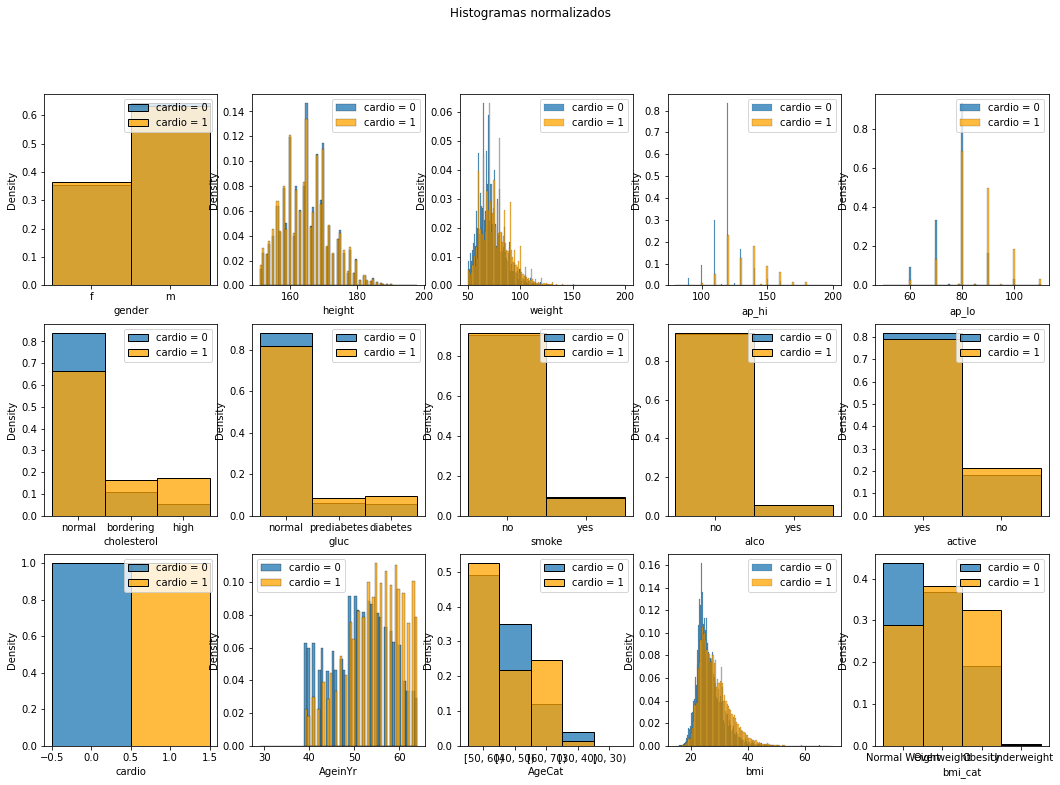

In [29]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18,12))
fig.suptitle('Histogramas normalizados')
for c, ax in zip(data.columns[:-1], axes.flatten()):
    sns.histplot(data = data.loc[data['cardio']==0, c].dropna(), stat = 'density', ax = ax, kde = False )
    sns.histplot(data = data.loc[data['cardio']==1, c].dropna(), stat = 'density', kde=False, ax=ax, color = 'orange')
    ax.legend(['cardio = 0', 'cardio = 1'])

# 3.Transform the Categorical Variables: Creating Dummy Variables

<AxesSubplot:>

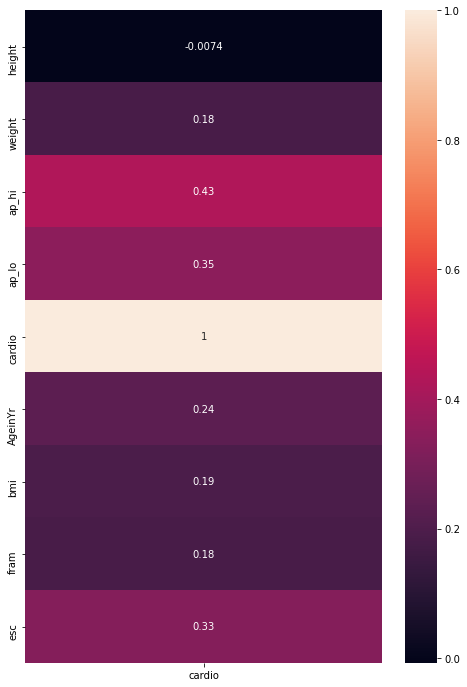

In [30]:
plt.figure(figsize=(8,12))
sns.heatmap(data.corr()[['cardio']], annot=True)

In [31]:
#Seleccionamos las variables categoricas para transformarlas en dummies
categoricals = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

enc = OneHotEncoder(drop = "first")
X = data[categoricals]
enc.fit(X)
enc.categories_

[array(['f', 'm'], dtype=object),
 array(['bordering', 'high', 'normal'], dtype=object),
 array(['diabetes', 'normal', 'prediabetes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [32]:
dummies = enc.transform(X).toarray()
dummies
dummies_df = pd.DataFrame(dummies)
dummies_df

col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals))] 
                                                                 #range(len(categoricals)) = 0 a 6
col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]
dummies_df.columns = col_names_drop_first
variables_numericas = ["height", "weight", "AgeinYr", "ap_hi", "ap_lo", "bmi", "fram", "esc"]
data_numerica = data[variables_numericas]
data_final = pd.concat([dummies_df, data_numerica,data["cardio"]], axis = 1)
data_final.head()

,gender_m,cholesterol_high,cholesterol_normal,gluc_normal,gluc_prediabetes,smoke_yes,alco_yes,active_yes,height,weight,AgeinYr,ap_hi,ap_lo,bmi,fram,esc,cardio
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,168,62.0,50,110.0,80.0,21.97,14,2,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,156,85.0,55,140.0,90.0,34.93,15,10,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,165,64.0,51,130.0,70.0,23.51,14,6,1
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,169,82.0,48,150.0,100.0,28.71,20,2,1
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,156,56.0,47,100.0,60.0,23.01,9,3,0


In [33]:
X = data_final.drop("cardio", axis = 1)
y = data_final["cardio"]

In [34]:
# Separamos un set de testeo para evaluar el modelo
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 0)

In [35]:
# Estandarizamos los datos para que la regularización sea correcta
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [37]:
np.where(np.isnan(data.ap_hi))

(array([ 6816, 11506, 13231, 16006, 34996, 38981, 39153, 44269, 50896,
        54817]),)

In [36]:
#ajuste del modelo

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train_std, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
accuracy_score(y_train, lr.predict(X_train_std))

In [ ]:
sns.heatmap(confusion_matrix(y_train, lr.predict(X_train_std)), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')

In [ ]:
lr.predict_proba(X_train_std[y_train==0])[:,1]

In [ ]:
# Histograma de probabilidades
sns.histplot(data = lr.predict_proba(X_train_std[y_train==0])[:,1], stat = 'density')
sns.histplot(data = lr.predict_proba(X_train_std[y_train==1])[:,1], stat = 'density', color = 'orange')
ylim = plt.ylim()
plt.vlines(0.5, ylim[0], ylim[1])
plt.ylim(ylim)
plt.legend(['Umbral', 'cardio = 0', 'cardio = 1'])

In [ ]:
#Dada la naturaleza del probelma, conviene utilizar una estrategia que impida clasificar como pacientes sanos a aquellos que están en riesgo.

In [ ]:
umbral = 0.2
probs = lr.predict_proba(X_train_std)[:,1]
y_pred_train = probs > umbral

In [ ]:
accuracy_score(y_train, y_pred_train)

In [ ]:
sns.heatmap(confusion_matrix(y_train, y_pred_train), annot=True, fmt='4d')
plt.xlabel('Predichos')
plt.ylabel('Reales')